In [1]:
!git clone https://github.com/parhamzm/Beijing-Pollution-DataSet

fatal: destination path 'Beijing-Pollution-DataSet' already exists and is not an empty directory.


In [2]:
!ls Beijing-Pollution-DataSet

pollution.csv  polution_dataSet.npy  README.md


In [0]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import random_split

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from numpy import array
from numpy import hstack

# **Data Pre Processing**

In [0]:
DATA_DIR = "Beijing-Pollution-DataSet/"
from pandas import read_csv
from datetime import datetime
from random import randint
import random

def select_random_rows(seq_start=0, seq_end=12000, rand_percent=20):
    rand_num = int((20*(seq_end-seq_start))/100)
    rand_gen = random.sample(range(seq_start, seq_end), rand_num)
    return rand_gen

def apply_nan(sequence, seq_start=0, seq_end=12000, rand_percent=20):
    for i in range(0, 8):
        rand_r = select_random_rows(seq_start=seq_start, seq_end=seq_end, rand_percent=rand_percent)
        np.put(sequence[seq_start:seq_end, i], rand_r, np.nan)
    return sequence

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps=11, n_samples=12000, start_from=0):
	X, y = list(), list()
	for i in range(start_from, (start_from + n_samples)):
        # find the end of this pattern
		end_ix = i + n_steps
        # check if we are beyond the dataset
        # gather input and output parts of the pattern
		seq_x = sequences[i:end_ix, :]
		seq_y = sequences[end_ix, 0]
		y.append(seq_y)
		X.append(seq_x)
  
	return array(X), array(y)


data = np.load(DATA_DIR + 'polution_dataSet.npy')
scaled_data = data
n_timesteps = 11
xxx, train_y = split_sequences(sequences=scaled_data, n_steps=n_timesteps, n_samples=15000, start_from=0)

xxx, test_y = split_sequences(sequences=scaled_data, n_steps=n_timesteps, n_samples=3000, start_from=15000)
data1 = np.load(DATA_DIR + 'polution_dataSet.npy')

# specify the number of lag hours
n_timesteps = 11
n_features = 8


n = apply_nan(data, seq_start=0, seq_end=21000, rand_percent=20)

In [5]:
# example of evaluating a model after an imputer transform
from numpy import nan
from pandas import read_csv
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import numpy.ma as ma
data = np.where(np.isnan(data), ma.array(data, mask=np.isnan(data)).mean(axis=0), data)


occurrences = np.count_nonzero(np.isnan(data1[:, :]))
print("Number of Nan in Dataset : => ", occurrences)

dataset = data
print(data.shape)
train_X, train_y1 = split_sequences(sequences=dataset, n_steps=n_timesteps, n_samples=15000, start_from=0)
# train_y = train_y.reshape(len(train_y), 1)
test_X, test_y1 = split_sequences(sequences=dataset, n_steps=n_timesteps, n_samples=3000, start_from=15000)

Number of Nan in Dataset : =>  0
(43799, 8)


In [0]:
class GRU(torch.nn.Module):
    def __init__(self, n_features=8, n_output=1, seq_length=11, n_hidden_layers=233, n_layers=1):
        super(GRU, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_output = n_output

        self.n_hidden = n_hidden_layers # number of hidden states
        self.n_layers = n_layers # number of LSTM layers (stacked)
        
        # define RNN with specified parameters
        # bath_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.GRU(input_size=self.n_features,
                          hidden_size=self.n_hidden,
                          num_layers=self.n_layers,
                          batch_first=True)
        
        # last, fully connected layer
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, self.n_output)

    def forward(self, x, hidden):
        # hidden_state = torch.zeros(self.n_layers, x.size(0), self.n_hidden).requires_grad_()
        # cell_state = torch.zeros(self.n_layers, x.size(0), self.n_hidden).requires_grad_()
        batch_size = x.size(0)

        rnn_out, hidden = self.rnn(x, hidden)
        rnn_out = rnn_out.contiguous().view(batch_size, -1)

        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        out = self.l_linear(rnn_out)
        return out, hidden

In [0]:
torch.manual_seed(13)
model = GRU(n_features=8, n_output=1, seq_length=11, n_hidden_layers=233, n_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [8]:
import time
start_time = time.time()
hidden = None
hidden_test = None
# train_X, train_y
epochs = 100
model.train()
batch_size = 200
running_loss_history = []
val_running_loss_history = []
for epoch in range(epochs):
    running_loss = 0.0
    val_running_loss = 0.0
    model.train()
    for b in range(0, len(train_X), batch_size):
        inpt = train_X[b:b+batch_size, :, :]
        target = train_y[b:b+batch_size]

        # print("Input Shape :=> ", inpt.shape)

        x_batch = torch.tensor(inpt, dtype=torch.float32)    
        y_batch = torch.tensor(target, dtype=torch.float32)

        output, hidden = model(x_batch, hidden)

        hidden = hidden.data
        loss = criterion(output.view(-1), y_batch)

        running_loss += loss.item()

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 

    else:
        
        with torch.no_grad(): # it will temprerorerly set all the required grad flags to be false
            model.eval()
            for b in range(0, len(test_X), batch_size):
                inpt = test_X[b:b+batch_size, :, :]
                target = test_y[b:b+batch_size]   

                x_batch_test = torch.tensor(inpt, dtype=torch.float32)
                y_batch_test = torch.tensor(target, dtype=torch.float32)

                # model.init_hidden(x_batch_test.size(0))

                output_test, hidden_test = model(x_batch_test, hidden_test)

                hidden_test = hidden_test.data
                loss_test = criterion(output_test.view(-1), y_batch_test)

                val_running_loss += loss_test.item()

    val_epoch_loss = val_running_loss / len(test_X)
    val_running_loss_history.append(val_epoch_loss)
    epoch_loss = running_loss / len(train_X)
    running_loss_history.append(epoch_loss)
    print('step : ' , epoch , ' Train loss : ' , epoch_loss, ', Valid Loss : => ', val_epoch_loss)
    print("***->>>-----------------------------------------------<<<-***")



total_time = time.time() - start_time
print("===========================================================")
print("*********************************************************")
print("The total Training Time is Equal with ==> : {0} Sec.".format(total_time))
print("*********************************************************")
print("===========================================================")

step :  0  Train loss :  3.324034200826039e-05 , Valid Loss : =>  7.925129293774565e-05
***->>>-----------------------------------------------<<<-***
step :  1  Train loss :  2.3834512270210933e-05 , Valid Loss : =>  8.588926711430152e-05
***->>>-----------------------------------------------<<<-***
step :  2  Train loss :  2.440852333093062e-05 , Valid Loss : =>  8.926124311983585e-05
***->>>-----------------------------------------------<<<-***
step :  3  Train loss :  2.481215700584774e-05 , Valid Loss : =>  7.135632665206988e-05
***->>>-----------------------------------------------<<<-***
step :  4  Train loss :  2.2777253168169407e-05 , Valid Loss : =>  8.587889885529875e-05
***->>>-----------------------------------------------<<<-***
step :  5  Train loss :  2.4918310379143805e-05 , Valid Loss : =>  7.356523256748914e-05
***->>>-----------------------------------------------<<<-***
step :  6  Train loss :  2.3549678176641463e-05 , Valid Loss : =>  7.076206772277752e-05
***->>>-

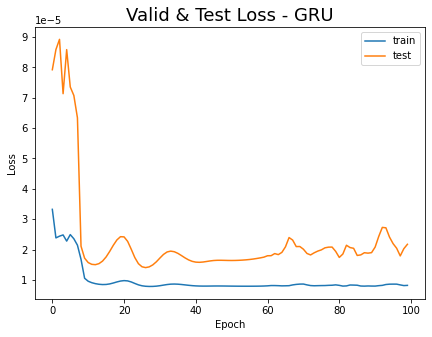

In [9]:
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Valid & Test Loss - GRU", fontsize=18)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(running_loss_history, label='train')
plt.plot(val_running_loss_history, label='test')
# pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
x, y1 = split_sequences(dataset, n_timesteps, n_samples=100, start_from=20500)
x1, y = split_sequences(data1, n_timesteps, n_samples=100, start_from=20500)
future = 100
window_size = 11
# preds = dataset[14989:15000, :].tolist()
# print(len(preds))
# print(preds)
model.eval()
x = torch.tensor(x, dtype=torch.float32)
# for i in range (future):

res, hid = model(x, None)
# print(preds[11:])

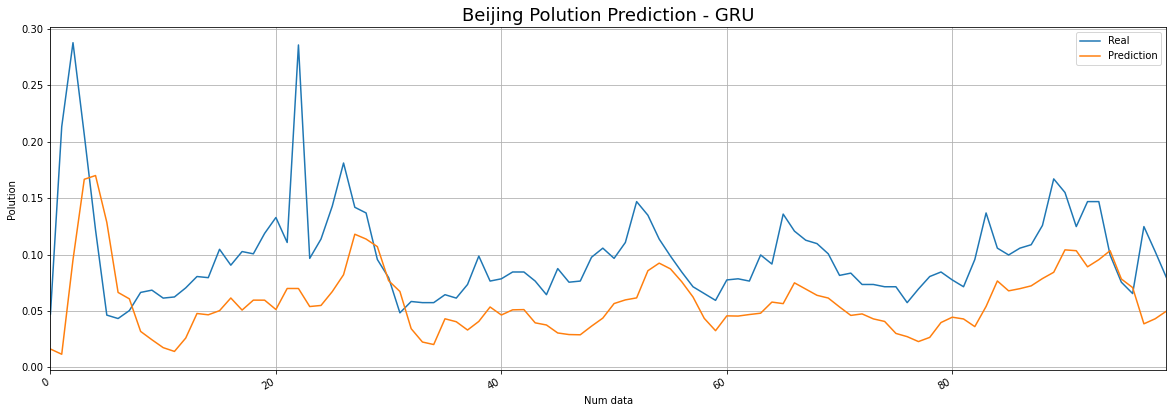

In [14]:
fig = plt.figure(figsize=(20, 7))
plt.title("Beijing Polution Prediction - GRU", fontsize=18)
plt.ylabel('Polution')
plt.xlabel('Num data')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()

# plt.plot(data[15000:15100, 0])
plt.plot(y, label="Real")
# plt.plot(preds[12:])
# print(res.shape)
plt.plot(res.detach().numpy(), label="Prediction")
plt.legend()
plt.show()

In [15]:
test_x, test_y1 = split_sequences(data, n_timesteps, n_samples=3000, start_from=18000)
test_x1, test_y = split_sequences(data1, n_timesteps, n_samples=3000, start_from=18000)

model.eval()

test_running_loss = 0
with torch.no_grad(): # it will temprerorerly set all the required grad flags to be false
    model.eval()
    for b in range(0, len(test_x), batch_size):
        inpt = test_x[b:b+batch_size, :, :]
        target = test_y[b:b+batch_size]   

        x_batch_test = torch.tensor(inpt, dtype=torch.float32)
        y_batch_test = torch.tensor(target, dtype=torch.float32)

        # model.init_hidden(x_batch_test.size(0))

        output_test, hidden_test = model(x_batch_test, hidden_test)

        hidden_test = hidden_test.data
        loss_test = criterion(output_test.view(-1), y_batch_test)

        test_running_loss += loss_test.item()

    test_epoch_loss = test_running_loss / len(test_x)

print("##########################################################")
print(">>>>---------------------------------------------------<<<<")
print(">>>>----------***************************--------------<<<<")
print("**** Test Loss :==>>> ", test_epoch_loss)
print(">>>>----------***************************--------------<<<<")
print(">>>>---------------------------------------------------<<<<")
print("##########################################################")

##########################################################
>>>>---------------------------------------------------<<<<
>>>>----------***************************--------------<<<<
**** Test Loss :==>>>  1.5681098331697285e-05
>>>>----------***************************--------------<<<<
>>>>---------------------------------------------------<<<<
##########################################################
